# Example of using PySpark to find metal interactions

## Imports and variables

In [1]:
from pyspark import SparkConf, SparkContext                    
from mmtfPyspark.io import mmtfReader
from mmtfPyspark.interactions import InteractionFilter, GroupInteractionExtractor
from mmtfPyspark.filters import ContainsLProteinChain, Resolution
from mmtfPyspark.webFilters import Pisces
import matplotlib.pyplot as plt
import pandas as pd
import py3Dmol
import time

                                                               
# Create variables                                             
APP_NAME = "MMTF_Spark"                                        
path = "./resources/mmtf_full_sample/"                            

# Configure Spark                                              
conf = SparkConf().setAppName(APP_NAME).setMaster("local[*]")  
sc = SparkContext(conf=conf)                                   

## Define Variables

In [2]:
# input parameters
sequenceIdentityCutoff = 30
resolution = 2.5
minInteractions = 4
maxInteractions = 6
distanceCutoff = 3.0

# chemical component codes of metals in different oxidation states
metals = {"V","CR","MN","MN3","FE","FE2","CO","3CO","NI","3NI", "CU","CU1","CU3","ZN","MO","4MO","6MO"}

## Read PDB and create PISCES non-redundant set

In [3]:
pdb = mmtfReader.read_sequence_file(path, sc)
pdb = pdb.filter(Pisces(sequenceIdentity = sequenceIdentityCutoff, resolution = resolution))         

## Setup criteria for metal interactions

In [4]:
interactions_filter = InteractionFilter()
interactions_filter.set_distance_cutoff(distanceCutoff)
interactions_filter.set_min_interactions(minInteractions)
interactions_filter.set_max_interactions(maxInteractions)
interactions_filter.set_query_groups(True, metals)

#Exclude non-polar interactions
interactions_filter.set_target_elements(False, ['H','C','P'])

## Tabulate interactions in a Dataframe

In [5]:
interactions = GroupInteractionExtractor().get_interactions(pdb,interactions_filter).cache()
print(f"Metal interactions: {interactions.count()}")

Metal interactions: 3344


## Select interacting atoms and orientational order parameters (q4-q6)

In [6]:
interactions = interactions.select("pdbId", \
                "q4","q5","q6", \
                "element0","groupNum0","chain0", \
                "element1","groupNum1","chain1","distance1", \
                "element2","groupNum2","chain2","distance2", \
                "element3","groupNum3","chain3","distance3", \
                "element4","groupNum4","chain4","distance4", \
                "element5","groupNum5","chain5","distance5", \
                "element6","groupNum6","chain6","distance6").cache();

# show some example interactions
ds = interactions.dropDuplicates(["pdbId"])
df = ds.toPandas() # convert to pandas dataframe to fit table in jupyter notebook cell
df.head()

,pdbId,q4,q5,q6,element0,groupNum0,chain0,element1,groupNum1,chain1,...,chain4,distance4,element5,groupNum5,chain5,distance5,element6,groupNum6,chain6,distance6
0,1M4L,0.810257,0.425694,NaN,Zn,1308,A,N,196,A,...,A,2.245983,N,69,A,2.034816,None,None,None,0.0
1,1VS0,0.471705,0.147339,NaN,Zn,9001,B,O,483,B,...,B,1.691909,O,481,B,1.897172,None,None,None,0.0
2,1YIX,0.683122,NaN,NaN,Zn,601,A,O,205,A,...,A,2.179354,None,None,None,0.000000,None,None,None,0.0
3,2ETV,0.622655,NaN,NaN,Ni,1,A,O,495,A,...,A,2.234011,None,None,None,0.000000,None,None,None,0.0
4,3A32,0.966021,NaN,NaN,Zn,708,A,N,166,A,...,A,2.064647,None,None,None,0.000000,None,None,None,0.0


## Count Unique interactions by metal

In [7]:
print("Unique interactions by metal: ")
unique_ds = interactions.groupBy(['element0']).count().sort("count")
unique_ds.show()

Unique interactions by metal: 
+--------+-----+
|element0|count|
+--------+-----+
|      Mo|   23|
|      Co|   86|
|      Cu|   88|
|      Ni|  166|
|      Fe|  405|
|      Mn|  435|
|      Zn| 2141|
+--------+-----+



## Plot histogram for unique interactions count

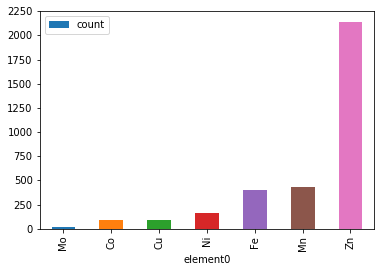

In [8]:
unique_df = unique_ds.toPandas()
unique_df.plot(x='element0', y='count', kind='bar')

## Terminate Spark